## Project 1 Notebook

By: Joanie Weaver

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# What are the 5 most popular trips that you would call "commuter trips"?

I'm defining commuter trips as single trips that meet the following criteria:
* The start station is different from the end station
* The trip falls during "commuting hours" which I'm defining as between 6am-10am and 4pm-8pm.
* I'm not restricting the day of the week to weekdays since many workers in the area may still commute during these hours on weekends.

I'm also considering the direction of the trip differently. Thus I'm treating trips differently if they start or end at different points. For example, a trip going from Kaiser Hospital to Mezes is different from a trip starting at Mezes ending as Kaiser Hospital.

In [4]:
%%bigquery top_commuting_trips

select COUNT(trip_id) as trips,start_station_name,end_station_name
from `bigquery-public-data.san_francisco.bikeshare_trips`
where (EXTRACT(HOUR FROM start_date) > 6 and EXTRACT(HOUR FROM start_date) <10) or (EXTRACT(HOUR FROM start_date) > 16 
and extract(HOUR FROM start_date) <20) and (start_station_id != end_station_id)
GROUP BY start_station_name,end_station_name
ORDER BY trips desc 

In [5]:
top_commuting_trips

,trips,start_station_name,end_station_name
0,5461,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
1,5280,Harry Bridges Plaza (Ferry Building),2nd at Townsend
2,4563,Steuart at Market,2nd at Townsend
3,4522,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome
4,4460,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building)
...,...,...,...
1966,1,Park at Olive,San Francisco Caltrain (Townsend at 4th)
1967,1,Santa Clara at Almaden,San Francisco Caltrain (Townsend at 4th)
1968,1,Mountain View Caltrain Station,San Francisco Caltrain (Townsend at 4th)
1969,1,California Ave Caltrain Station,San Francisco Caltrain (Townsend at 4th)


Below I will show a table and a chart of the top five "commuter trips". Each trip is defined by its start and end stations.

In [7]:
top_five=top_commuting_trips[:5]
top_five

,trips,start_station_name,end_station_name
0,5461,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
1,5280,Harry Bridges Plaza (Ferry Building),2nd at Townsend
2,4563,Steuart at Market,2nd at Townsend
3,4522,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome
4,4460,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building)


In [19]:
top_five.loc[:,"commute"]=top_five.loc[:,"start_station_name"]+" to "+top_five.loc[:,"end_station_name"]

In [20]:
top_five.loc[:,("trips","commute")]

,trips,commute
0,5461,San Francisco Caltrain 2 (330 Townsend) to Tow...
1,5280,Harry Bridges Plaza (Ferry Building) to 2nd at...
2,4563,Steuart at Market to 2nd at Townsend
3,4522,Harry Bridges Plaza (Ferry Building) to Embarc...
4,4460,San Francisco Caltrain (Townsend at 4th) to Ha...


Text(0.5, 0, 'Commute')

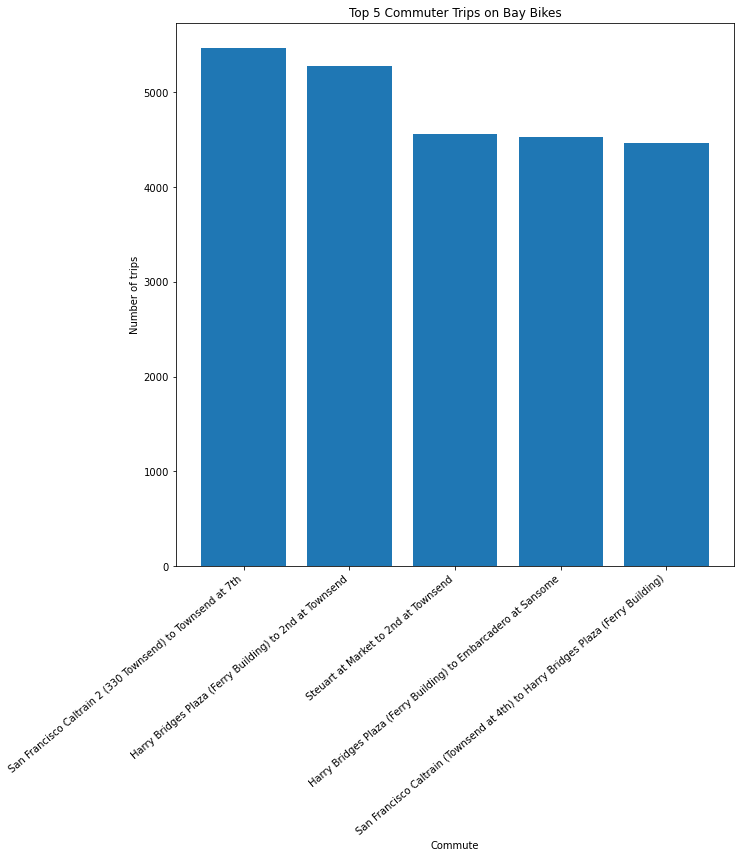

In [33]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation=40,ha="right")
plt.bar(top_five.commute,top_five.trips)
plt.title("Top 5 Commuter Trips on Bay Bikes")
plt.ylabel("Number of trips")
plt.xlabel("Commute")

As we can see from the plot and table above the top five "commuter trips" as defined by my criteria above are: San Francisco Caltrain 2 (330 Townsend) to Townsend at 7th, Harry Bridges Plaza (Ferry Building) to 2nd at Townsend, Steuart at Market to 2nd at Townsend, Harry Bridges Plaza (Ferry Building) to Embarcadero as Sansome, and San Francisco Caltrain (Townsend at 4th) to Harry Bridges Plaza (Ferry Building).

# What are your recommendations for offers (justify based on your findings)?

I have two types of recommendations I believe we should offer.

1. Time based recommendations to encourage more usage during days/hours we see low usage
2. Location based recommendations to encourage usage to bring bikes back to stations we see frequently hit 0 bikes available.

I'll outline the usage data inspiring these recommendations below.

## Time based recommendations

### What days of the week have the least usage?

Below I will query for data that gives me the number of trips per day by subscriber_type and day of the week.

In [59]:
%%bigquery trips_by_day_of_week

SELECT COUNT(trip_id) as trips, subscriber_type, EXTRACT(DAYOFWEEK FROM start_date) as day_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN "Sunday"
           WHEN 2 THEN "Monday"
           WHEN 3 THEN "Tuesday"
           WHEN 4 THEN "Wednesday"
           WHEN 5 THEN "Thursday"
           WHEN 6 THEN "Friday"
           WHEN 7 THEN "Saturday"
           END AS day,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY day, subscriber_type, day_int
ORDER BY subscriber_type,trips asc

In [80]:
trips_by_day_of_week=trips_by_day_of_week.sort_values("day_int")
pd.pivot_table(trips_by_day_of_week,index="day",values="trips",columns="subscriber_type")

subscriber_type,Customer,Subscriber
day,,
Friday,19929,140048
Monday,15142,154795
Saturday,29244,31035
Sunday,25908,25467
Thursday,16612,160296
Tuesday,14737,169668
Wednesday,15237,165530


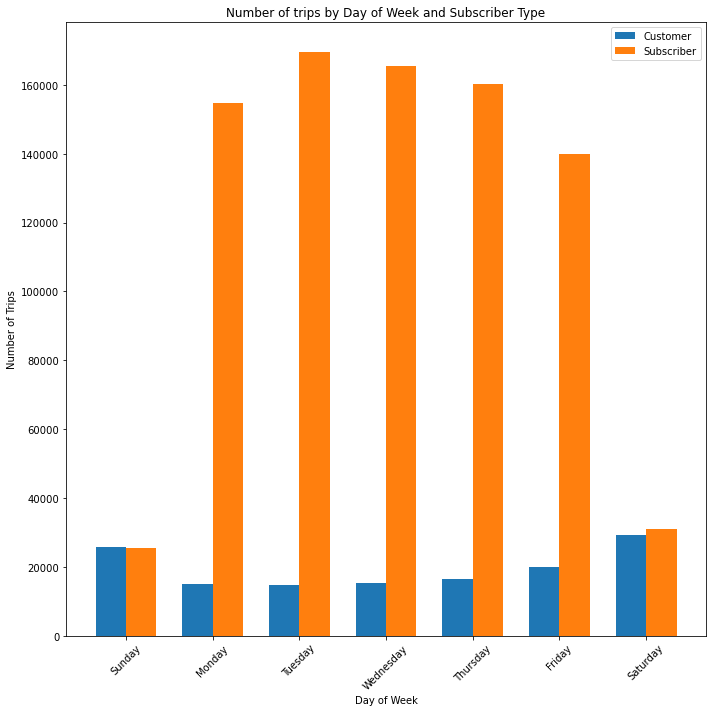

In [88]:
labels=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
customers=trips_by_day_of_week[trips_by_day_of_week.subscriber_type=="Customer"]
subscribers=trips_by_day_of_week[trips_by_day_of_week.subscriber_type=="Subscriber"]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize= (10,10))
rects1 = ax.bar(x - width/2, customers.trips, width, label='Customer')
rects2 = ax.bar(x + width/2, subscribers.trips, width, label='Subscriber')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Trips')
ax.set_xlabel("Day of Week")
ax.set_title('Number of trips by Day of Week and Subscriber Type')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=45)
ax.legend()

fig.tight_layout()

plt.show()

From the table and plot above, we can see that there are way more subscriber trips in general than customers. Since our subscribers pay us for a daily/monthly/annual pass, we want to keep these so we should look at days where subscriber usage is lowest to not cause any negative effects by decreasing bikes on their high usage days. 

Subscriber usage is lowest over the weekend and next lowest on Fridays. Customers have the highest usage on the weekends. We should consider a promotion to take advantage of the customer affinity for weekend riding and encourage more customers to use it over the weekends when subscriber usage is down to see if we can increase our overall customers.

### What hours of the day have the least usage?

Below I will query for data that gives me the number of trips per hour of the day by subscriber_type and hour of the day.

In [64]:
%%bigquery trips_by_hour

SELECT COUNT(trip_id) as trips, EXTRACT(HOUR FROM start_date) as hour, subscriber_type,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY hour, subscriber_type
ORDER BY subscriber_type,trips asc

In [85]:
trips_by_hour=trips_by_hour.sort_values("hour")
pd.pivot_table(trips_by_hour,index="hour",values="trips",columns="subscriber_type")

subscriber_type,Customer,Subscriber
hour,,
0,848,2081
1,639,972
2,413,464
3,208,397
4,160,1238
5,303,4795
6,945,19574
7,2585,64946
8,5293,127171


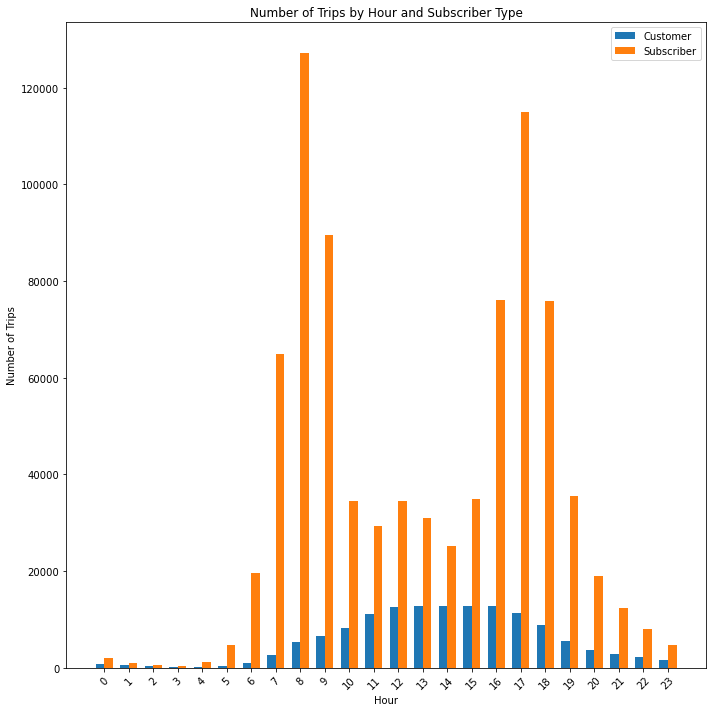

In [87]:
labels=np.arange(24)
customers=trips_by_hour[trips_by_hour.subscriber_type=="Customer"]
subscribers=trips_by_hour[trips_by_hour.subscriber_type=="Subscriber"]


x = np.arange(24)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize= (10,10))
rects1 = ax.bar(x - width/2, customers.trips, width, label='Customer')
rects2 = ax.bar(x + width/2, subscribers.trips, width, label='Subscriber')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Trips')
ax.set_xlabel("Hour")
ax.set_title('Number of Trips by Hour and Subscriber Type')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=45)
ax.legend()

fig.tight_layout()

plt.show()

From the table and chart above, we can see that the overall usage is way down during the middle of the night from 10pm-6am. This is likely when people are sleeping and we won't be able to change these rates even with promotions so we should consider hours outside of that timeframe. We can see that usage is down in the middle of the day from 10am-4pm. This is again where customers have their highest usage so I'd recommend again to take advantage of this user group's interest in that time period by offering a customer promotion during that time period to encourage usage when overall usage rates are down.

## What stations most frequently hit zero bikes available?

Below I will query for data that gives me the stations that most frequently experience having 0 bikes available.

In [89]:
#This is view 2
%%bigquery stations_id

SELECT COUNT(station_id)as count, station_id
FROM `bigquery-public-data.san_francisco.bikeshare_status`
WHERE bikes_available = 0
GROUP BY station_id
ORDER BY count desc 

In [92]:
#This is view 1
%%bigquery stations_name

SELECT start_station_name as station_name,start_station_id AS station_id
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY station_name,station_id

In [94]:
#Joining the views to get counts with station names
%%bigquery stations_name_counts

SELECT `level-calculus-301101.bike_trip_data.zero_bikes2`.station_id, `level-calculus-301101.bike_trip_data.zero_bikes2`.count, `level-calculus-301101.bike_trip_data.zero_bikes`.station_name
FROM `level-calculus-301101.bike_trip_data.zero_bikes2`
INNER JOIN `level-calculus-301101.bike_trip_data.zero_bikes`
ON `level-calculus-301101.bike_trip_data.zero_bikes`.station_id=`level-calculus-301101.bike_trip_data.zero_bikes2`.station_id

These are the top 10 stations that experience having zero bikes available:

In [103]:
stations_name_counts.sort_values("count",ascending=False).head(10)

,station_id,count,station_name
59,62,44844,2nd at Folsom
42,45,44728,Commercial at Montgomery
47,48,35903,Embarcadero at Vallejo
57,60,32980,Embarcadero at Sansome
40,41,32505,Clay at Battery
67,70,32027,San Francisco Caltrain (Townsend at 4th)
70,73,31733,Grant Avenue at Columbus Avenue
73,76,30800,Market at 4th
60,63,27938,Howard at 2nd
77,82,25496,Broadway St at Battery St


When there are zero bikes available at a station, no new trips can start from that station. We should consider a promotion that encourages trips by all customer types to end at these top ten locations above, in order to help reduce the number of times these stations experience having zero bikes available. This will potentially increase ridership at those stations by providing more bikes.

## Summary

In summary, I have the following recommendations for offers:
* Offer a promotion, such as discounted single rides, to increase overall ridership over the weekends when our subscriber usage is down
* Offer a promotion, such as discounted single rides, to increase overall ridership during the weekdays from 10am-4pm when overall usage is down
* Offer a promotion or incentive, such as discounts on the subscriber pass or a points system to redeem for discounts on single rides, for riders to return bikes to the top ten stations that hit 0 bikes available.